In [1]:
import os
from itertools import combinations
import pandas as pd
import numpy as np
import cv2
from itertools import cycle
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score,roc_curve,auc,precision_recall_fscore_support,accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader,WeightedRandomSampler
from torch.utils.data import Dataset as BaseDataset

In [2]:
def create_dataframe(anno_dir,normal_images_dir,test_size = 0.2):
    df_labels = pd.read_csv(anno_dir)
    df_labels['image'] = '../' + df_labels['image']
    
    # load normal images as new df
    rel_img_path = [os.path.relpath(x) for x in glob.glob(normal_images_dir)]
    df_nb = pd.DataFrame(rel_img_path,columns=['image'])
    df_nb['label'] = 0
    
    # concat dfs
    df = pd.concat([df_labels,df_nb], ignore_index=True)
    
    # encode labels
    df['label'] = df['label'].astype('category')
    df['label_encoded'] = df['label'].cat.codes.astype('int64')
    
    # create splits
    X_train, _ = train_test_split(df['image'].values,test_size=test_size,random_state=1,stratify=df['label'].values)
    df['split'] = ['train' if x in X_train else 'valid' for x in df['image'].values]
    df.rename(columns={'image':'file_path'},inplace=True)
    return df

In [3]:
def get_minority_transforms(img_size,img_mean,img_std):
    minority_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return minority_transforms

def get_train_transforms(img_size,img_mean,img_std):
    train_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.OneOf(
                            [
                                A.CLAHE(p=1),
                                A.RandomBrightnessContrast(p=1),
                                A.RandomGamma(p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.Sharpen(p=1),
                                A.Blur(blur_limit=3, p=1),
                                A.MotionBlur(blur_limit=3, p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.RandomBrightnessContrast(p=1),
                                A.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return train_transforms

def get_valid_transforms(img_size,img_mean,img_std):
    valid_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return valid_transforms

def get_strong_transforms(img_size,img_mean,img_std):
    strong_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
                        A.OneOf(
                            [
                                A.CLAHE(p=1),
                                A.RandomBrightnessContrast(p=1),
                                A.RandomGamma(p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.Sharpen(p=1),
                                A.Blur(blur_limit=3, p=1),
                                A.MotionBlur(blur_limit=3, p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.RandomBrightnessContrast(p=1),
                                A.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return strong_transforms

def get_weak_transforms(img_size,img_mean,img_std):
    weak_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return weak_transforms

def get_resize_transforms(img_size,img_mean,img_std):
    resize_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return resize_transforms

In [4]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df, 
            augmentation=None,
            minority_augmentation=None,
            visualize = False
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.minority_augmentation = minority_augmentation
        self.visualize = visualize
        self.labels = sorted(self.df['label_encoded'].unique().tolist())
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.ids[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        label = self.df.loc[i,'label_encoded']
        
        # apply augmentations
        if self.minority_augmentation and label in [1,2,3,4,5]:
            image = self.minority_augmentation(image=image)['image']
        elif self.augmentation:
            image = self.augmentation(image=image)['image']
        
        # Revert Normalize to visualize the image
            if self.visualize:
                invTrans = A.Normalize(mean=[-x/y for x,y in zip(img_mean,img_std)],
                                       std=[1/x for x in img_std],
                                       max_pixel_value=1.0,
                                       always_apply=True)
                image = image.detach().cpu().numpy().transpose(1,2,0)
                image = invTrans(image=image)['image']
                image = (image*255).astype(np.uint8)
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

In [5]:
class VisionModel:
    def __init__(self,
                 model_architecture,
                 num_classes,
                 dropout,
                 dropout_percent=0.5,
                 pretrained=True,
                 device='cuda',
                 checkpoint=False,
                 eval_mode=True):
        self.model_architecture = model_architecture
        self.num_classes = num_classes
        self.dropout = dropout
        self.dropout_percent = dropout_percent
        self.pretrained = pretrained
        self.device = torch.device(device)
        self.checkpoint=checkpoint
        self.eval_mode = eval_mode
        
        self._load_model()

    def _load_model(self):
        self.model = timm.create_model(self.model_architecture, pretrained=self.pretrained, num_classes=self.num_classes)
        num_ftrs = self.model.get_classifier().in_features
        if self.dropout:
            self.model.classifier = nn.Sequential(
                                    nn.Dropout(self.dropout_percent),
                                    nn.Linear(num_ftrs,self.num_classes)
            )
        else:
            self.model.classifier = nn.Linear(num_ftrs, self.num_classes)
        if self.checkpoint:
            self.model.load_state_dict(torch.load(self.checkpoint))
        if self.eval_mode:
            self.model = self.model.eval()
        
        self.model = self.model.to(self.device)   
        
    def __call__(self):
        return self.model

In [6]:
class Evaluate:
    def __init__(self,model,dataset):
        self.model = model()
        self.model_class = model
        self.dataset = dataset
        self.class_ids = self.dataset.labels
        self.label_array = np.array([], dtype='int64')
        self.prediction_array = np.array([], dtype='int64')
        self.softmax_array = np.array([], dtype='float64')
        
        self._perform_cls()
        self._fpr_tpr_calc()
        
    def _perform_cls(self):
        with torch.no_grad():
            self.model.eval()
            for self.images, self.labels in self.dataset:
                self.images = self.images.to(self.model_class.device).unsqueeze(0)
                #labels = labels.to(device)
                self.cls_outputs = self.model(self.images)
                self.softmax_array = np.append(self.softmax_array,F.softmax(self.cls_outputs,dim=1).detach().cpu().numpy())
                self.softmax_array = np.reshape(self.softmax_array,(-1,self.model.num_classes))
                _, self.predicted = torch.max(self.cls_outputs.data, 1)
                #_,labels = torch.max(labels.data, 0)
                self.label_array = np.append(self.label_array, self.labels)
                self.prediction_array = np.append(self.prediction_array, self.predicted.detach().cpu().numpy())
        
        self.label_array_oh = np.zeros((self.label_array.size, self.label_array.max()+1), dtype=int)
        self.label_array_oh[np.arange(self.label_array.size),self.label_array] = 1
    
    @property
    def print_cls_report(self):
        return classification_report(self.label_array, self.prediction_array, digits=4,zero_division=0)
    
    @property
    def cls_report(self):
        pre_rec_fs_sups = dict()
        
        for label in ['micro','macro','weighted']:
            prfs = precision_recall_fscore_support(
                self.label_array,
                self.prediction_array,
                average=label,
                zero_division=0
            )
            
            
            pre_rec_fs_sups[label] = {'precision' : prfs[0],
                                      'recall' : prfs[1],
                                      'f1-score' : prfs[2],
                                      'support' : prfs[3]
                                     }
        
        per_label_prfs = precision_recall_fscore_support(
            self.label_array,
            self.prediction_array,
            average=None,
            zero_division=0
        )
        
        for class_id in self.class_ids:
                pre_rec_fs_sups[class_id] = {'precision':per_label_prfs[0][class_id],
                                             'recall': per_label_prfs[1][class_id],
                                             'f1-score' : per_label_prfs[2][class_id],
                                             'support' : per_label_prfs[3][class_id]
                                            }
        
        acc = accuracy_score(self.label_array,self.prediction_array)
        pre_rec_fs_sups['accuracy'] = acc
        
        return pre_rec_fs_sups
    
    @property
    def auc(self):
        aucs = dict()
        for label in ['micro','macro','weighted']:
            aucs[label] = roc_auc_score(
                self.label_array_oh,
                self.softmax_array,
                multi_class="ovr",
                average=label,
            )
        
        aucs['macro_ovo'] = roc_auc_score(
                self.label_array_oh,
                self.softmax_array,
                multi_class="ovo",
                average='macro',
        )
        
        per_label_auc = roc_auc_score(
            self.label_array_oh,
            self.softmax_array,
            multi_class="ovr",
            average=None,
        )   
        
        for i,value in enumerate(per_label_auc):
            aucs[f'{i}'] = value

        return aucs
    
    def _fpr_tpr_calc(self):
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        # store the fpr, tpr, and roc_auc for all averaging strategies
        self.fpr, self.tpr, self.roc_auc = dict(), dict(), dict()
        # Compute micro-average ROC curve and ROC area for OvR strategy
        self.fpr["micro"], self.tpr["micro"], _ = roc_curve(self.label_array_oh.ravel(), self.softmax_array.ravel(),drop_intermediate=True)
        self.roc_auc["micro"] = auc(self.fpr["micro"], self.tpr["micro"])
        
        interp_tpr = np.interp(fpr_grid,self.fpr['micro'],self.tpr['micro'])
        interp_tpr[0] = 0.0
        self.fpr['micro'] = fpr_grid
        self.tpr['micro'] = interp_tpr
        
        
        self.tresholds = dict()
        for i in range(self.model.num_classes):
            self.fpr[i], self.tpr[i], self.tresholds[i] = roc_curve(self.label_array_oh[:, i], self.softmax_array[:, i])
            self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(self.model.num_classes):
            mean_tpr += np.interp(fpr_grid, self.fpr[i], self.tpr[i])  # linear interpolation

        # Average it and compute AUC
        mean_tpr /= self.model.num_classes

        self.fpr["macro"] = fpr_grid
        self.tpr["macro"] = mean_tpr
        self.roc_auc["macro"] = auc(self.fpr["macro"], self.tpr["macro"])
        
        # Compute macro-average ROC curve and ROC area for OvO strategy
        pair_list = list(combinations(self.class_ids,2))
        
        pair_scores = []
        self.tpr['macro_ovo'] = np.zeros_like(fpr_grid)
        mean_tpr = dict()
        for ix, (label_a, label_b) in enumerate(pair_list):

            a_mask = self.label_array == label_a
            b_mask = self.label_array == label_b
            ab_mask = np.logical_or(a_mask, b_mask)

            a_true = a_mask[ab_mask]
            b_true = b_mask[ab_mask]

            idx_a = np.flatnonzero(np.array(self.class_ids) == label_a)[0]
            idx_b = np.flatnonzero(np.array(self.class_ids) == label_b)[0]

            fpr_a, tpr_a, _ = roc_curve(a_true, self.softmax_array[ab_mask, idx_a])
            fpr_b, tpr_b, _ = roc_curve(b_true, self.softmax_array[ab_mask, idx_b])

            mean_tpr[ix] = np.zeros_like(fpr_grid)
            mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
            mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
            mean_tpr[ix] /= 2
            mean_score = auc(fpr_grid, mean_tpr[ix])
            pair_scores.append(mean_score)
            self.tpr['macro_ovo'] += mean_tpr[ix]
            
        self.tpr['macro_ovo'] /= sum(1 for pair in enumerate(pair_list))
        self.fpr['macro_ovo'] = fpr_grid
        self.roc_auc['macro_ovo'] = np.average(pair_scores)
    
    def roc(self,contents=[]):
        assert contents is not None
        fig, ax = plt.subplots(figsize=(6, 6))
        
        colors = cycle(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"])
        
        for class_id, color in zip([x for x in contents if x not in ['micro','macro']], colors):
            plt.plot(
                self.fpr[class_id],
                self.tpr[class_id],
                label=f"ROC curve for {class_id} (AUC = {self.roc_auc[class_id]:.2f})",
                color=color     
            )
        
        if 'micro' in contents:
            plt.plot(
                self.fpr["micro"],
                self.tpr["micro"],
                label=f"micro-average ROC curve (AUC = {self.roc_auc['micro']:.2f})",
                color="deeppink",
                linestyle=":",
                linewidth=4,
            )
        
        if 'macro' in contents:
            plt.plot(
                self.fpr["macro"],
                self.tpr["macro"],
                label=f"macro-average ROC curve (AUC = {self.roc_auc['macro']:.2f})",
                color="navy",
                linestyle=":",
                linewidth=4,
            )
            
        plt.plot([0, 1], [0, 1], "k--")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend()
        return fig,ax

In [7]:
def cv_cls_report(ev_models,labels,folds,digits=4):
    cv_cls_report = {}
    labels.extend(['micro','macro', 'weighted'])
    folds = range(folds)
    accs = []
    for fold in folds:
        accs.append(ev_models[fold].cls_report['accuracy'])

    cv_cls_report['accuracy'] = [round(np.mean(accs),digits),round(np.std(accs),digits)]

    avg_prec = {}
    avg_rec = {}
    avg_f1 = {}
    for label in labels:
        precs = []
        recs = []
        f1s = []
        sups = []
        for fold in folds:
            precs.append(ev_models[fold].cls_report[label]['precision'])
            recs.append(ev_models[fold].cls_report[label]['recall'])
            f1s.append(ev_models[fold].cls_report[label]['f1-score'])
            
        avg_prec[label] = [round(np.mean(precs),digits),round(np.std(precs),digits)]
        avg_rec[label] = [round(np.mean(recs),digits),round(np.std(recs),digits)]
        avg_f1[label] = [round(np.mean(f1s),digits),round(np.std(f1s),digits)]

        metric_dict = {}
        metric_dict['precision'] = avg_prec[label]
        metric_dict['recall'] = avg_rec[label]
        metric_dict['f1-score'] = avg_f1[label]
        cv_cls_report[label] = metric_dict
        
    return cv_cls_report

In [8]:
def cv_auc(ev_models,contents,n_folds,digits=4):
    avg_auc = {}
    for class_id in contents:
        values = []
        for fold in range(n_folds):
            if class_id == 'weighted':
                values.append(ev_models[fold].auc[class_id])
            else:
                values.append(ev_models[fold].roc_auc[class_id])
        avg_auc[class_id] = [round(np.mean(values),digits),round(np.std(values),digits)]
    return avg_auc

In [9]:
def cv_roc(ev_models,contents,folds,ax,title='Receiver Operating Characteristic',save=None):
    avg_tpr = {}
    avg_fpr = {}
    avg_auc = {}
    std_auc = {}

    colors = cycle(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"])

    for class_id, color in zip([x for x in contents if x not in ['micro','macro','macro_ovo']], colors):
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)
        aucs = []
        for fold in range(folds):
            mean_tpr += np.interp(fpr_grid, ev_models[fold].fpr[class_id], ev_models[fold].tpr[class_id])
            aucs.append(ev_models[fold].roc_auc[class_id])

        avg_tpr[class_id] = mean_tpr / folds
        avg_fpr[class_id] = fpr_grid
        avg_auc[class_id] = np.mean(aucs)
        std_auc[class_id] = np.std(aucs)
        
        ax.plot(
            avg_fpr[class_id],
            avg_tpr[class_id],
            label=f"Severity {class_id} (AUC = {avg_auc[class_id]:.2f} $\pm$ {std_auc[class_id]:.2f})" if class_id != 0 else f"Healthy (AUC = {avg_auc[class_id]:.2f} $\pm$ {std_auc[class_id]:.2f})",
            color=color     
        )
        
    if 'micro' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['micro'])
            fprs.append(ev_models[fold].fpr['micro'])
            aucs.append(ev_models[fold].roc_auc['micro'])
        avg_fpr["micro"] = np.mean(fprs,axis=0)
        avg_tpr["micro"] = np.mean(tprs,axis=0)
        avg_auc["micro"] = np.mean(aucs)
        std_auc["micro"] = np.std(aucs)
         
        ax.plot(
            avg_fpr["micro"],
            avg_tpr["micro"],
            label=f"micro-average (AUC = {avg_auc['micro']:.2f} $\pm$ {std_auc['micro']:.2f})",
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )
        
    if 'macro' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['macro'])
            fprs.append(ev_models[fold].fpr['macro'])
            aucs.append(ev_models[fold].roc_auc['macro'])
        avg_fpr["macro"] = np.mean(fprs,axis=0)
        avg_tpr["macro"] = np.mean(tprs,axis=0)
        avg_auc["macro"] = np.mean(aucs)
        std_auc["macro"] = np.std(aucs)
            
        ax.plot(
            avg_fpr["macro"],
            avg_tpr["macro"],
            label=f"macro-average (AUC = {avg_auc['macro']:.2f} $\pm$ {std_auc['macro']:.2f})",
            color="navy",
            linestyle=":",
            linewidth=4,
        )
        
    if 'macro_ovo' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['macro_ovo'])
            fprs.append(ev_models[fold].fpr['macro_ovo'])
            aucs.append(ev_models[fold].roc_auc['macro_ovo'])
        avg_fpr["macro_ovo"] = np.mean(fprs,axis=0)
        avg_tpr["macro_ovo"] = np.mean(tprs,axis=0)
        avg_auc["macro_ovo"] = np.mean(aucs)
        std_auc["macro_ovo"] = np.std(aucs)
            
        ax.plot(
            avg_fpr["macro"],
            avg_tpr["macro"],
            label=f"OvO macro-average (AUC = {avg_auc['macro_ovo']:.2f} $\pm$ {std_auc['macro_ovo']:.2f})",
            color="cyan",
            linestyle=":",
            linewidth=4,
        )

    ax.plot([0, 1], [0, 1], "k--")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend()

In [10]:
# Data
anno_dir = '../../export/annotations/covidx_anno.csv'
normal_images_dir = '../../data/Covidx/data_with_classes/*/normal/*'
img_size = 224
img_mean = IMAGENET_DEFAULT_MEAN
img_std = IMAGENET_DEFAULT_STD
df = create_dataframe(anno_dir,normal_images_dir)
n_folds = 5

In [11]:
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=1)
train_ids_dict = {}
test_ids_dict = {}
for fold, (train_ids,test_ids) in enumerate(kfold.split(np.zeros(len(df)),y=df['label_encoded'])):
    # Keep ids for later
    train_ids_dict[fold] = train_ids
    test_ids_dict[fold] = test_ids

In [12]:
for fold in range(n_folds):
    df.loc[test_ids_dict[fold],'test_fold'] = fold
df['test_fold'] = df['test_fold'].astype('int64')

In [13]:
valid_dataset = Dataset(
    df.loc[df['test_fold']==0,:], 
    augmentation=get_valid_transforms(img_size,img_mean,img_std), 
)

In [14]:
strong_dataset = Dataset(
    df, 
    augmentation=get_strong_transforms(800,img_mean,img_std), 
    visualize=True
)

In [15]:
weak_dataset = Dataset(
    df, 
    augmentation=get_weak_transforms(800,img_mean,img_std), 
    visualize=True
)

In [16]:
vis_dataset = Dataset(
    df, 
    augmentation=get_resize_transforms(800,img_mean,img_std), 
    visualize=True
)

In [17]:
# Evaluate all cv models in loop
vision_models_baseline = {}
ev_models_baseline = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_baseline[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_fold{fold}.pth')
    
    ev_models_baseline[fold] = Evaluate(vision_models_baseline[fold],valid_dataset)

In [18]:
# Evaluate all cv models in loop
vision_models_baseline_weak = {}
ev_models_baseline_weak = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_baseline_weak[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_baseline_weak_fold{fold}.pth')
    
    ev_models_baseline_weak[fold] = Evaluate(vision_models_baseline_weak[fold],valid_dataset)

In [19]:
# Evaluate all oversampling cv models in loop
vision_models_os = {}
ev_models_os = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_os[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_oversampling_fold{fold}.pth')
    
    ev_models_os[fold] = Evaluate(vision_models_os[fold],valid_dataset)

In [20]:
# Evaluate all oversampling cv models in loop
vision_models_os_weak = {}
ev_models_os_weak = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_os_weak[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_oversampling_weak_fold{fold}.pth')
    
    ev_models_os_weak[fold] = Evaluate(vision_models_os_weak[fold],valid_dataset)

In [21]:
# Evaluate all oversampling cv models in loop
vision_models_minaug = {}
ev_models_minaug = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_minaug[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_minaug_fold{fold}.pth')
    
    ev_models_minaug[fold] = Evaluate(vision_models_minaug[fold],valid_dataset)

In [22]:
# Evaluate all oversampling cv models in loop
vision_models_minaugv2 = {}
ev_models_minaugv2 = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_minaugv2[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_minaugv2_fold{fold}.pth')
    
    ev_models_minaugv2[fold] = Evaluate(vision_models_minaugv2[fold],valid_dataset)

In [23]:
# Evaluate all oversampling cv models in loop
vision_models_minaugv3 = {}
ev_models_minaugv3 = {}
for fold in range(n_folds):
    valid_dataset = Dataset(
        df.loc[df['test_fold']==fold,:].sample(3270,replace=False,random_state=1), 
        augmentation=get_valid_transforms(img_size,img_mean,img_std), 
    )
    
    vision_models_minaugv3[fold] = VisionModel('convnext_small',
                                      num_classes=6,
                                      dropout=True,
                                      checkpoint=f'./models/convnext_small_covidx_severity_minaugv3_fold{fold}.pth')
    
    ev_models_minaugv3[fold] = Evaluate(vision_models_minaugv3[fold],valid_dataset)

In [24]:
cv_cls_report(ev_models_baseline,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.9352, 0.0035],
 0: {'precision': [0.9721, 0.0037],
  'recall': [0.9948, 0.0015],
  'f1-score': [0.9833, 0.0013]},
 1: {'precision': [0.7216, 0.04],
  'recall': [0.5584, 0.0187],
  'f1-score': [0.6291, 0.0223]},
 2: {'precision': [0.7102, 0.0206],
  'recall': [0.6201, 0.0375],
  'f1-score': [0.6615, 0.0252]},
 3: {'precision': [0.5833, 0.0499],
  'recall': [0.5462, 0.0524],
  'f1-score': [0.5618, 0.0381]},
 4: {'precision': [0.24, 0.0772],
  'recall': [0.1886, 0.1139],
  'f1-score': [0.1987, 0.0892]},
 5: {'precision': [0.0, 0.0], 'recall': [0.0, 0.0], 'f1-score': [0.0, 0.0]},
 'micro': {'precision': [0.9352, 0.0035],
  'recall': [0.9352, 0.0035],
  'f1-score': [0.9352, 0.0035]},
 'macro': {'precision': [0.5379, 0.0153],
  'recall': [0.4847, 0.02],
  'f1-score': [0.5058, 0.0169]},
 'weighted': {'precision': [0.9289, 0.004],
  'recall': [0.9352, 0.0035],
  'f1-score': [0.9311, 0.0037]}}

In [25]:
cv_cls_report(ev_models_baseline_weak,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.9314, 0.0048],
 0: {'precision': [0.9806, 0.0021],
  'recall': [0.9861, 0.0044],
  'f1-score': [0.9833, 0.0016]},
 1: {'precision': [0.6741, 0.0406],
  'recall': [0.5088, 0.0537],
  'f1-score': [0.5771, 0.0322]},
 2: {'precision': [0.6257, 0.0385],
  'recall': [0.7397, 0.0376],
  'f1-score': [0.6761, 0.0165]},
 3: {'precision': [0.5894, 0.0442],
  'recall': [0.4655, 0.142],
  'f1-score': [0.503, 0.0887]},
 4: {'precision': [0.2083, 0.1143],
  'recall': [0.0819, 0.052],
  'f1-score': [0.1137, 0.0661]},
 5: {'precision': [0.1, 0.2],
  'recall': [0.0667, 0.1333],
  'f1-score': [0.08, 0.16]},
 'micro': {'precision': [0.9314, 0.0048],
  'recall': [0.9314, 0.0048],
  'f1-score': [0.9314, 0.0048]},
 'macro': {'precision': [0.5297, 0.0469],
  'recall': [0.4748, 0.0309],
  'f1-score': [0.4889, 0.0383]},
 'weighted': {'precision': [0.9289, 0.0034],
  'recall': [0.9314, 0.0048],
  'f1-score': [0.9283, 0.0048]}}

In [26]:
cv_cls_report(ev_models_os,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.9272, 0.006],
 0: {'precision': [0.9889, 0.0017],
  'recall': [0.9791, 0.0037],
  'f1-score': [0.9839, 0.0017]},
 1: {'precision': [0.5936, 0.0195],
  'recall': [0.6362, 0.0633],
  'f1-score': [0.6121, 0.0269]},
 2: {'precision': [0.6449, 0.0405],
  'recall': [0.6463, 0.0627],
  'f1-score': [0.6433, 0.0356]},
 3: {'precision': [0.4796, 0.0414],
  'recall': [0.5642, 0.2079],
  'f1-score': [0.4911, 0.1221]},
 4: {'precision': [0.2775, 0.1184],
  'recall': [0.259, 0.0981],
  'f1-score': [0.2646, 0.1028]},
 5: {'precision': [0.2, 0.4],
  'recall': [0.1, 0.2],
  'f1-score': [0.1333, 0.2667]},
 'micro': {'precision': [0.9272, 0.006],
  'recall': [0.9272, 0.006],
  'f1-score': [0.9272, 0.006]},
 'macro': {'precision': [0.5307, 0.0758],
  'recall': [0.5308, 0.0469],
  'f1-score': [0.5214, 0.0577]},
 'weighted': {'precision': [0.9316, 0.0045],
  'recall': [0.9272, 0.006],
  'f1-score': [0.9281, 0.0058]}}

In [27]:
cv_cls_report(ev_models_os_weak,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.9191, 0.0052],
 0: {'precision': [0.9814, 0.0042],
  'recall': [0.9742, 0.0085],
  'f1-score': [0.9777, 0.0027]},
 1: {'precision': [0.5323, 0.0759],
  'recall': [0.6804, 0.0637],
  'f1-score': [0.5901, 0.0395]},
 2: {'precision': [0.6446, 0.0399],
  'recall': [0.5677, 0.0511],
  'f1-score': [0.6003, 0.0152]},
 3: {'precision': [0.5168, 0.022],
  'recall': [0.5763, 0.0857],
  'f1-score': [0.5434, 0.0499]},
 4: {'precision': [0.2018, 0.0596],
  'recall': [0.1895, 0.0661],
  'f1-score': [0.1873, 0.0567]},
 5: {'precision': [0.4, 0.3432],
  'recall': [0.2333, 0.1225],
  'f1-score': [0.2667, 0.152]},
 'micro': {'precision': [0.9191, 0.0052],
  'recall': [0.9191, 0.0052],
  'f1-score': [0.9191, 0.0052]},
 'macro': {'precision': [0.5462, 0.061],
  'recall': [0.5369, 0.0189],
  'f1-score': [0.5276, 0.026]},
 'weighted': {'precision': [0.9241, 0.0023],
  'recall': [0.9191, 0.0052],
  'f1-score': [0.9204, 0.0034]}}

In [28]:
cv_cls_report(ev_models_minaug,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.8907, 0.0081],
 0: {'precision': [0.9416, 0.005],
  'recall': [0.9713, 0.0133],
  'f1-score': [0.9561, 0.0043]},
 1: {'precision': [0.4263, 0.0571],
  'recall': [0.417, 0.0747],
  'f1-score': [0.415, 0.0344]},
 2: {'precision': [0.6253, 0.0693],
  'recall': [0.3712, 0.0699],
  'f1-score': [0.4574, 0.04]},
 3: {'precision': [0.5279, 0.0509],
  'recall': [0.4496, 0.1008],
  'f1-score': [0.4769, 0.0656]},
 4: {'precision': [0.2522, 0.1382],
  'recall': [0.3552, 0.1578],
  'f1-score': [0.2662, 0.1148]},
 5: {'precision': [0.2567, 0.1638],
  'recall': [0.3, 0.1633],
  'f1-score': [0.2671, 0.1465]},
 'micro': {'precision': [0.8907, 0.0081],
  'recall': [0.8907, 0.0081],
  'f1-score': [0.8907, 0.0081]},
 'macro': {'precision': [0.505, 0.0505],
  'recall': [0.4774, 0.0181],
  'f1-score': [0.4731, 0.0361]},
 'weighted': {'precision': [0.8852, 0.0056],
  'recall': [0.8907, 0.0081],
  'f1-score': [0.8841, 0.0045]}}

In [29]:
cv_cls_report(ev_models_minaugv2,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.8988, 0.0103],
 0: {'precision': [0.935, 0.0113],
  'recall': [0.989, 0.003],
  'f1-score': [0.9612, 0.0064]},
 1: {'precision': [0.4821, 0.0679],
  'recall': [0.3904, 0.0305],
  'f1-score': [0.4275, 0.0233]},
 2: {'precision': [0.6624, 0.052],
  'recall': [0.3197, 0.1102],
  'f1-score': [0.4185, 0.0986]},
 3: {'precision': [0.5131, 0.0828],
  'recall': [0.3833, 0.1098],
  'f1-score': [0.425, 0.0641]},
 4: {'precision': [0.283, 0.0694],
  'recall': [0.2181, 0.0742],
  'f1-score': [0.2403, 0.0556]},
 5: {'precision': [0.38, 0.1939],
  'recall': [0.3333, 0.1826],
  'f1-score': [0.3489, 0.1783]},
 'micro': {'precision': [0.8988, 0.0103],
  'recall': [0.8988, 0.0103],
  'f1-score': [0.8988, 0.0103]},
 'macro': {'precision': [0.5426, 0.0344],
  'recall': [0.439, 0.0293],
  'f1-score': [0.4702, 0.0319]},
 'weighted': {'precision': [0.8839, 0.0131],
  'recall': [0.8988, 0.0103],
  'f1-score': [0.8846, 0.0145]}}

In [30]:
cv_cls_report(ev_models_minaugv3,[0,1,2,3,4,5],n_folds)

{'accuracy': [0.9224, 0.0018],
 0: {'precision': [0.9721, 0.0057],
  'recall': [0.9851, 0.0023],
  'f1-score': [0.9785, 0.0027]},
 1: {'precision': [0.5628, 0.0392],
  'recall': [0.6203, 0.0895],
  'f1-score': [0.5859, 0.0407]},
 2: {'precision': [0.6887, 0.0521],
  'recall': [0.5406, 0.0685],
  'f1-score': [0.6003, 0.0254]},
 3: {'precision': [0.5128, 0.0583],
  'recall': [0.5059, 0.0695],
  'f1-score': [0.507, 0.0534]},
 4: {'precision': [0.2195, 0.062],
  'recall': [0.1762, 0.0693],
  'f1-score': [0.1913, 0.0604]},
 5: {'precision': [0.3045, 0.3669],
  'recall': [0.3167, 0.2906],
  'f1-score': [0.2705, 0.2531]},
 'micro': {'precision': [0.9224, 0.0018],
  'recall': [0.9224, 0.0018],
  'f1-score': [0.9224, 0.0018]},
 'macro': {'precision': [0.5434, 0.0604],
  'recall': [0.5241, 0.0539],
  'f1-score': [0.5222, 0.045]},
 'weighted': {'precision': [0.9201, 0.0028],
  'recall': [0.9224, 0.0018],
  'f1-score': [0.9199, 0.0027]}}

In [31]:
cv_auc(ev_models_baseline,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9947, 0.0013],
 1: [0.9761, 0.0028],
 2: [0.9785, 0.0022],
 3: [0.9788, 0.0029],
 4: [0.9771, 0.006],
 5: [0.989, 0.0104],
 'macro': [0.9824, 0.0016],
 'micro': [0.9967, 0.0002],
 'weighted': [0.9923, 0.0014],
 'macro_ovo': [0.882, 0.0038]}

In [32]:
cv_auc(ev_models_baseline_weak,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9832, 0.0049],
 1: [0.9541, 0.012],
 2: [0.9717, 0.0023],
 3: [0.9761, 0.0037],
 4: [0.973, 0.0153],
 5: [0.9816, 0.0281],
 'macro': [0.9733, 0.0037],
 'micro': [0.9955, 0.0004],
 'weighted': [0.9811, 0.0046],
 'macro_ovo': [0.8762, 0.0097]}

In [33]:
cv_auc(ev_models_os,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9917, 0.0013],
 1: [0.9725, 0.0093],
 2: [0.972, 0.0034],
 3: [0.9696, 0.0101],
 4: [0.9628, 0.0159],
 5: [0.9746, 0.032],
 'macro': [0.9739, 0.0072],
 'micro': [0.9952, 0.0003],
 'weighted': [0.9888, 0.0013],
 'macro_ovo': [0.8888, 0.0176]}

In [34]:
cv_auc(ev_models_os_weak,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9826, 0.0045],
 1: [0.9576, 0.0111],
 2: [0.9634, 0.006],
 3: [0.9725, 0.0047],
 4: [0.9308, 0.0498],
 5: [0.9617, 0.0354],
 'macro': [0.9614, 0.0121],
 'micro': [0.9936, 0.0015],
 'weighted': [0.9798, 0.0045],
 'macro_ovo': [0.8743, 0.0189]}

In [35]:
cv_auc(ev_models_minaug,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9464, 0.0109],
 1: [0.9231, 0.0193],
 2: [0.9397, 0.01],
 3: [0.9571, 0.0071],
 4: [0.9412, 0.0277],
 5: [0.9755, 0.0262],
 'macro': [0.9472, 0.0072],
 'micro': [0.9887, 0.0019],
 'weighted': [0.9454, 0.0107],
 'macro_ovo': [0.853, 0.0167]}

In [36]:
cv_auc(ev_models_minaugv2,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9736, 0.0125],
 1: [0.9474, 0.0161],
 2: [0.9584, 0.007],
 3: [0.9635, 0.0105],
 4: [0.9684, 0.0115],
 5: [0.9793, 0.0278],
 'macro': [0.9651, 0.0056],
 'micro': [0.9924, 0.0019],
 'weighted': [0.9713, 0.012],
 'macro_ovo': [0.8461, 0.0178]}

In [37]:
cv_auc(ev_models_minaugv3,[0,1,2,3,4,5,'macro','micro','weighted','macro_ovo'],n_folds=5,digits=4)

{0: [0.9817, 0.0021],
 1: [0.9621, 0.0067],
 2: [0.9687, 0.0035],
 3: [0.9731, 0.0032],
 4: [0.9625, 0.016],
 5: [0.9853, 0.0162],
 'macro': [0.9722, 0.0039],
 'micro': [0.9947, 0.0004],
 'weighted': [0.9798, 0.002],
 'macro_ovo': [0.8817, 0.0192]}

In [38]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_baseline,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='Baseline')
plt.savefig('export/roc_baseline.png')
plt.close()

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_os,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='ROS')
plt.savefig('export/roc_ros.png')
plt.close()

In [40]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_os_weak,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='ROS (weak)')
plt.savefig('export/roc_ros_weak.png')
plt.close()

In [41]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_minaug,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='Strong-Weak')
plt.savefig('export/roc_sw.png')
plt.close()

In [42]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_minaugv2,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='Strong-Strong')
plt.savefig('export/roc_ss.png')
plt.close()

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)
cv_roc(ev_models_minaugv3,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=ax,title='Weak-Strong')
plt.savefig('export/roc_ws.png')
plt.close()

Make Grid Image:

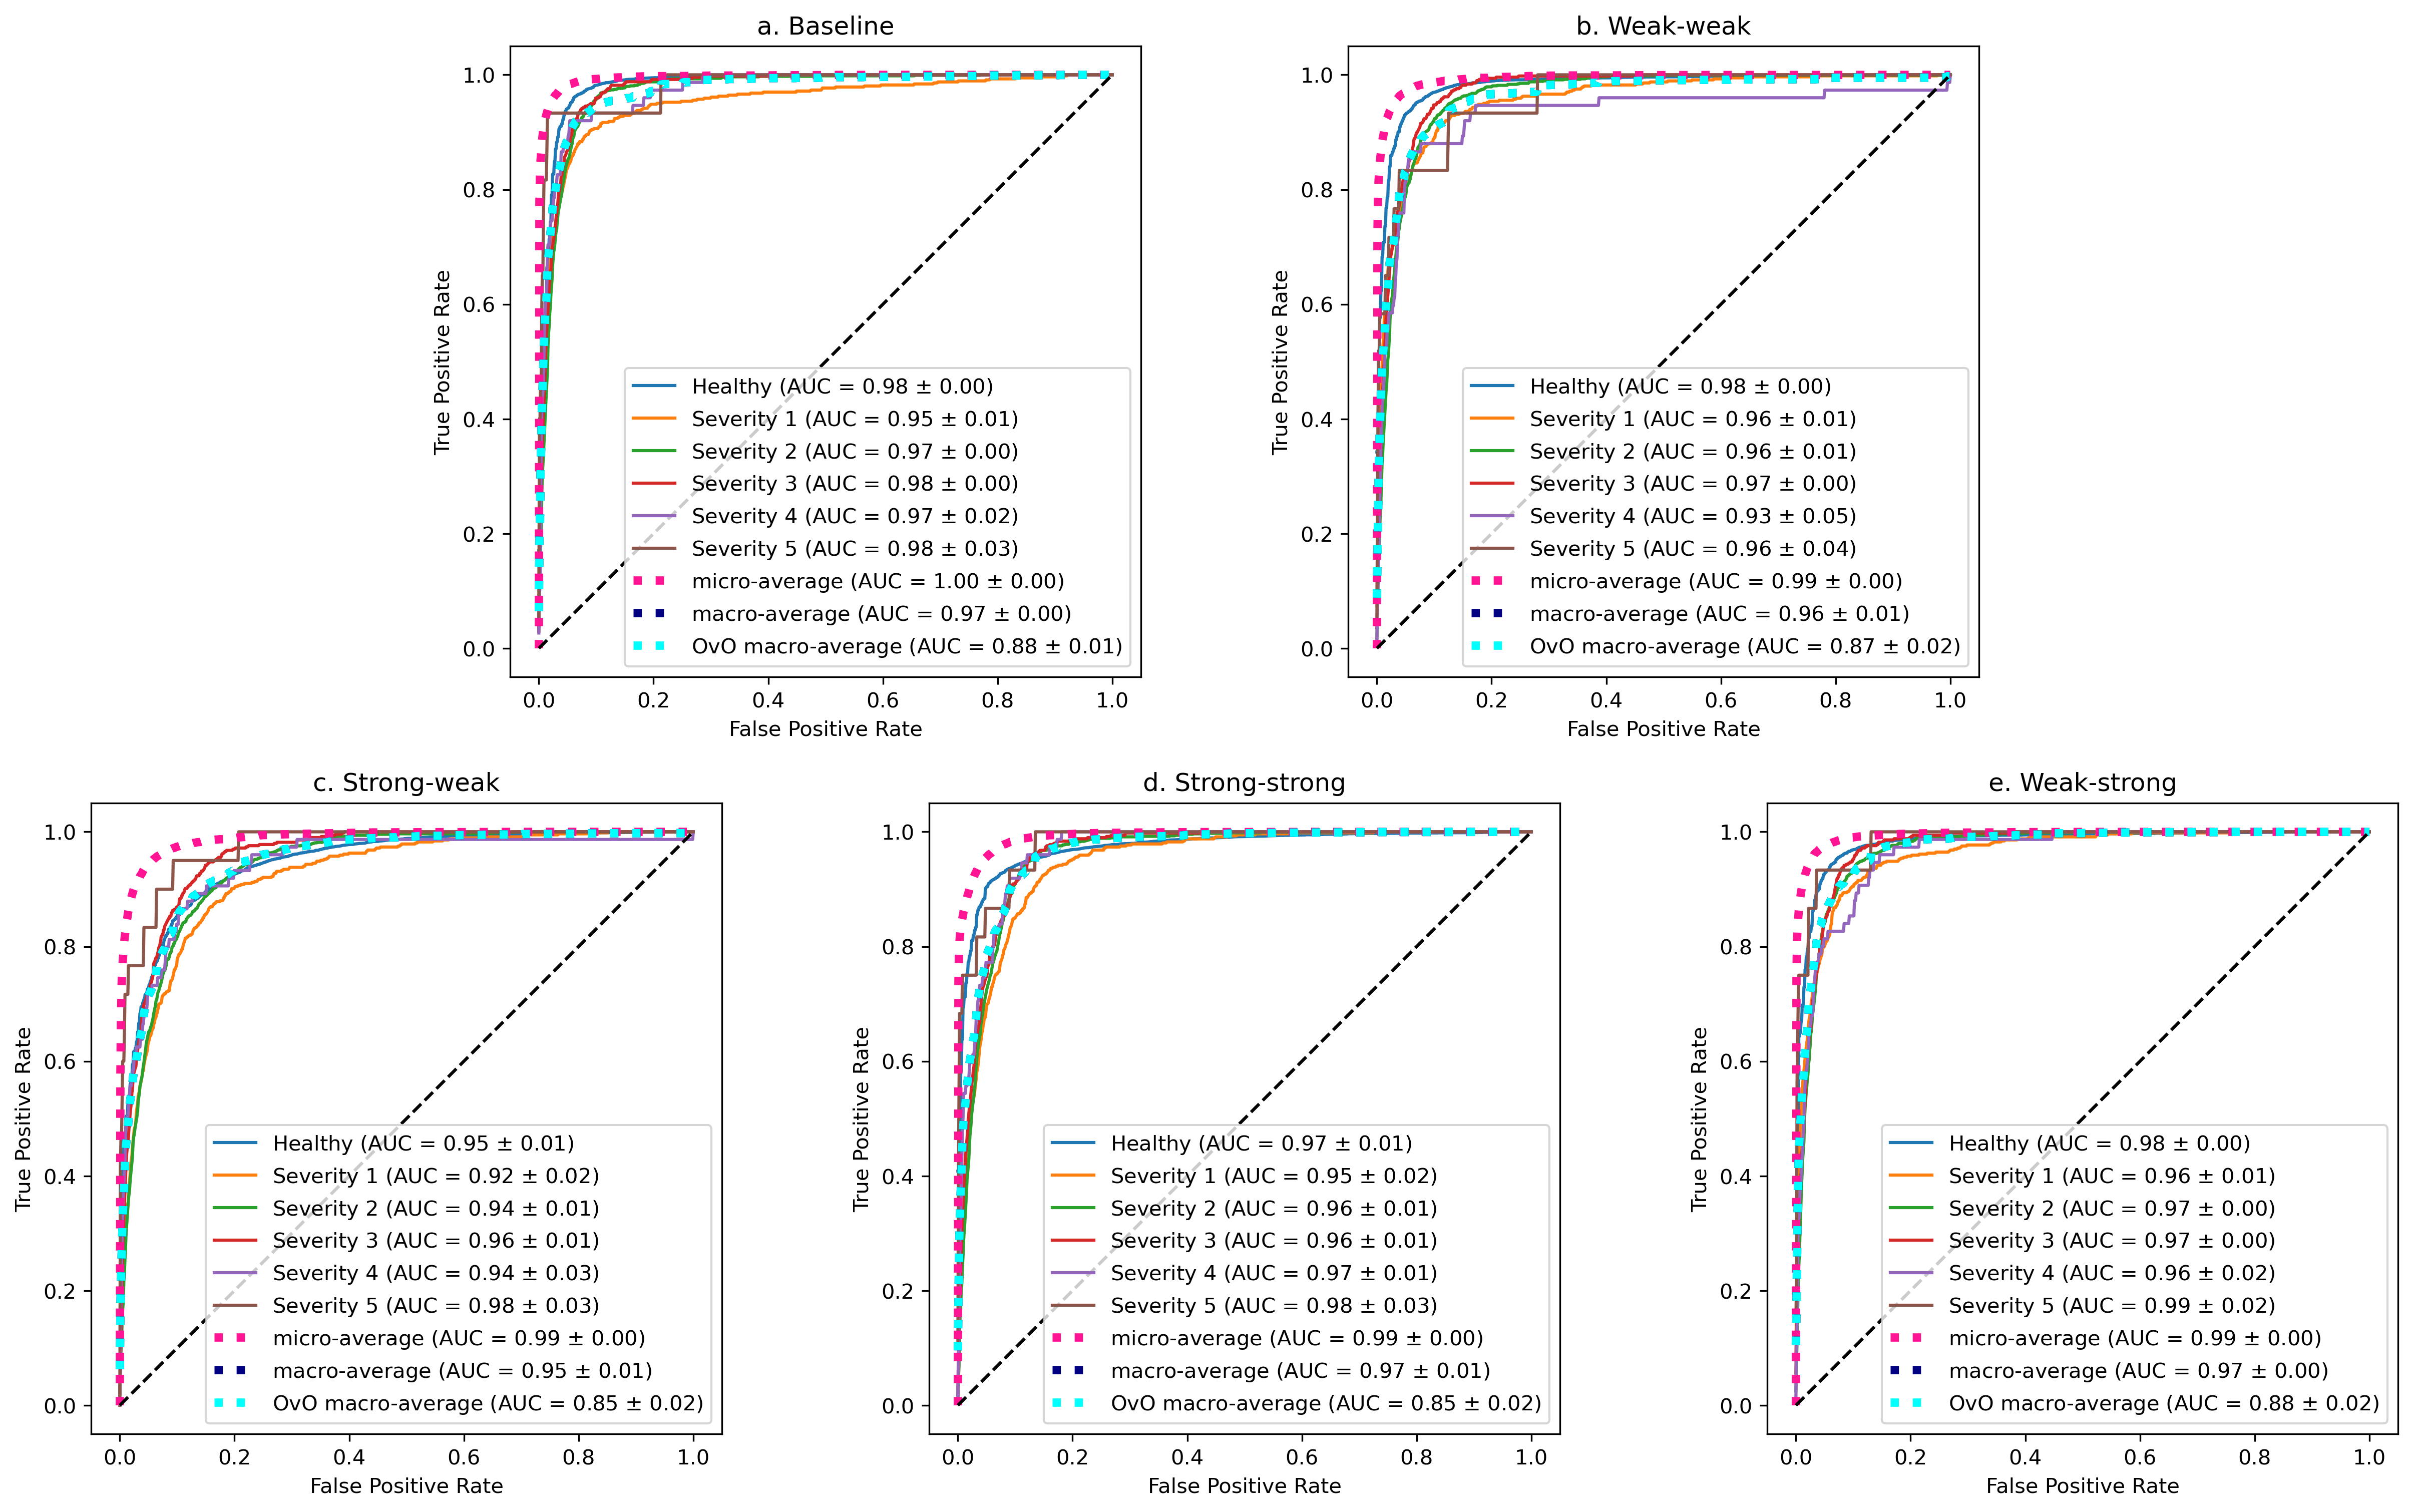

In [44]:
x = [['.','Baseline','Baseline','WW', 'WW','.'],
     ['SW','SW','SS','SS','WS','WS']]
axd = plt.figure(figsize=(21,12),constrained_layout=False, dpi=300).subplot_mosaic(x)
cv_roc(ev_models_baseline_weak,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=axd['Baseline'],title='a. Baseline')
cv_roc(ev_models_os_weak,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=axd['WW'],title='b. Weak-weak')
cv_roc(ev_models_minaug,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=axd['SW'],title='c. Strong-weak')
cv_roc(ev_models_minaugv2,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=axd['SS'],title='d. Strong-strong')
cv_roc(ev_models_minaugv3,[0,1,2,3,4,5,'macro','micro','macro_ovo'],5,ax=axd['WS'],title='e. Weak-strong')
plt.savefig('export/roc_grid.png',bbox_inches='tight', pad_inches=0.1,transparent=False)

### Visualize augmentations

Uncomment for new (random) images:

In [45]:
#plt.imsave('export/augmented_images/6_orig.png',vis_dataset[6][0])
#plt.close()

In [46]:
#for i in range(0,20):
#    plt.imsave(f'export/augmented_images/6_strong_{i}.png',strong_dataset[6][0])
#    plt.close()

In [47]:
#for i in range(0,20):
#    plt.imsave(f'export/augmented_images/6_weak_{i}.png',weak_dataset[6][0])
#    plt.close()